In [461]:
import pandas as pd
import numpy as np
import os

import pandas as pd
import numpy as np
import os

from itertools import combinations

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import io
import base64
import scipy.stats as stats

from itertools import combinations

from scipy.stats import shapiro, levene, ttest_ind
from joypy import joyplot

In [462]:
import seaborn as sns
print(sns.__version__)


0.13.2


In [463]:
null_values = {'N.A': np.nan, 'N': np.nan, 'N.A.': np.nan, "N,A": np.nan, 'N.A.': np.nan, 'N.A ': np.nan}

In [466]:
carpeta = "data_facenda" #"data_facenda" "data_raw"

# Lista para guardar todos los DataFrames leídos
list_dataframe = []

for archivo in os.listdir(carpeta):
    if "pellet" in archivo.lower() and archivo.lower().endswith('.xlsx'):
        ruta_completa = os.path.join(carpeta, archivo)
        
        try:
            # Leer el archivo como CSV con pandas
            df = pd.read_excel(ruta_completa, skiprows=10)
            cond = df["Fecha Prod."].notnull()
            df = df[cond]
            list_dataframe.append(df)
            print(f"Leído: {archivo} - Filas: {len(df)}")
        except Exception as e:
            print(f"Error leyendo {archivo}: {e}")

dataframes = pd.concat(list_dataframe)

Leído: SIG-FT-409 Control proceso Pellet y molienda Planta de alimentos balanceados V4 - Febrero 2025.xlsx - Filas: 490
Leído: SIG-FT-409 Control proceso Pellet y molienda Planta de alimentos balanceados V4 - Diciembre 2024.xlsx - Filas: 854
Leído: SIG-FT-409 Control proceso Pellet y molienda Planta de alimentos balanceados V4 - Enero 2025.xlsx - Filas: 682
Leído: SIG-FT-409 Control proceso Pellet y molienda Planta de alimentos balanceados V4 - Noviembre 2024.xlsx - Filas: 909


In [468]:
dataframes.shape

(2935, 30)

In [469]:

nov = pd.read_excel("data_raw/SIG-FT-411 Control proceso Temperaturas Planta de alimentos balanceados V2 (2).xlsx", sheet_name="NOVIEMBRE", skiprows=3)
dic = pd.read_excel("data_raw/SIG-FT-411 Control proceso Temperaturas Planta de alimentos balanceados V2 (3).xlsx", sheet_name="DICIEMBRE ", skiprows=3)
feb = pd.read_excel("data_raw/SIG-FT-411 Control proceso Temperaturas Planta de alimentos balanceados V2 (1).xlsx", sheet_name="FEBRERO", skiprows=3)
ene = pd.read_excel("data_raw/SIG-FT-411 Control proceso Temperaturas Planta de alimentos balanceados V2.xlsx", sheet_name="ENERO ", skiprows=3)

nov["dif1"] = nov["FECHA TOMA DE MUESTRA"].shift(1)
nov.loc[nov["SITIO TOMA DE MUESTRA"] == "PELLET 1", "FECHA TOMA DE MUESTRA"] = nov["dif1"]

dic["dif1"] = dic["FECHA TOMA DE MUESTRA"].shift(1)
dic.loc[dic["SITIO TOMA DE MUESTRA"] == "PELLET 1", "FECHA TOMA DE MUESTRA"] = dic["dif1"]

ene["dif1"] = ene["FECHA TOMA DE MUESTRA"].shift(1)
ene.loc[ene["SITIO TOMA DE MUESTRA"] == "PELLET 1", "FECHA TOMA DE MUESTRA"] = ene["dif1"]

feb["dif1"] = feb["FECHA TOMA DE MUESTRA"].shift(1)
feb.loc[feb["SITIO TOMA DE MUESTRA"] == "PELLET 1", "FECHA TOMA DE MUESTRA"] = feb["dif1"]



nov["dif1"] = nov["HORA"].shift(1)
nov.loc[nov["SITIO TOMA DE MUESTRA"] == "PELLET 1", "HORA"] = nov["dif1"]

dic["dif1"] = dic["HORA"].shift(1)
dic.loc[dic["SITIO TOMA DE MUESTRA"] == "PELLET 1", "HORA"] = dic["dif1"]

ene["dif1"] = ene["HORA"].shift(1)
ene.loc[ene["SITIO TOMA DE MUESTRA"] == "PELLET 1", "HORA"] = ene["dif1"]

feb["dif1"] = feb["HORA"].shift(1)
feb.loc[feb["SITIO TOMA DE MUESTRA"] == "PELLET 1", "HORA"] = feb["dif1"]

temp = pd.concat([nov, dic, feb, ene])
temp = temp.reset_index()
temp = temp.replace(null_values)
temp["FORMULACION"] = temp["FORMULACION"].str.strip()

temp["SITIO TOMA DE MUESTRA"].value_counts()

/var/folders/1g/77kw2x4j5678s_87_sqc1fpc0000gp/T/ipykernel_78478/2329287483.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = temp.replace(null_values)


SITIO TOMA DE MUESTRA
ACONDICIONADOR 1    90
PELLET 1            90
ENFRIADORA 1        90
Name: count, dtype: int64

In [470]:
cond1 = temp["SITIO TOMA DE MUESTRA"] == "PELLET 1"
cond2 = temp["TERMOMETRO AGROINDUSTRIA"].notnull()
temp_pellet = temp[cond1 & cond2]

cond1 = temp["SITIO TOMA DE MUESTRA"] == "ACONDICIONADOR 1"
cond3 = temp["TERMOMETRO AGROINDUSTRIA"].notnull()
temp_acond = temp[cond1 & (cond2 | cond3)]

cond1 = temp["SITIO TOMA DE MUESTRA"] == "ENFRIADORA 1"
temp_enf = temp[cond1 & (cond2 | cond3)]

In [485]:

dataframes["Fecha Prod."] = dataframes["Fecha Prod."].replace({"12/01/202": '2024-12-01', "10/02/202": "2024-10-02"})
dataframes[dataframes["Fecha Prod."] == '12/01/202']
dataframes["Fecha"] = pd.to_datetime(dataframes["Fecha Prod."], errors="ignore", infer_datetime_format=True).dt.date

dataframes = dataframes[dataframes["Punto"].notnull()]
dataframes["Muestra"] = dataframes["Muestra"].str.strip()
dataframes["Punto"] = dataframes["Punto"].str.strip()
dataframes["Producto"] = dataframes["Producto"].str.strip()

/var/folders/1g/77kw2x4j5678s_87_sqc1fpc0000gp/T/ipykernel_78478/152241821.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataframes["Fecha"] = pd.to_datetime(dataframes["Fecha Prod."], errors="ignore", infer_datetime_format=True).dt.date
/var/folders/1g/77kw2x4j5678s_87_sqc1fpc0000gp/T/ipykernel_78478/152241821.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  dataframes["Fecha"] = pd.to_datetime(dataframes["Fecha Prod."], errors="ignore", infer_datetime_format=True).dt.date


In [486]:
df_group = dataframes.groupby("OP", as_index=False).agg({"Código": "unique"})

# Contar la cantidad de elementos en cada lista
df_group["Código len"] = df_group["Código"].apply(len)
df_group_ops = df_group[df_group["Código len"]>1]
df_group_ops

,OP,Código,Código len


In [487]:
df_group = dataframes.groupby(["OP", "Fecha"],as_index=False).agg({"Código": "unique"})#.head(40) "Fecha"
df_group = df_group[df_group["OP"].isin(df_group_ops["OP"])]
#df_group["Código len"] = df_group["Código"].apply(len)
df_group["Código"] = df_group["Código"].astype('str')
#df_group["Código len"] = df_group["Código"].apply(lambda x: len(x))
df_group = df_group.drop_duplicates(["OP", "Código"])
#df_group_ops = df_group[df_group["Código len"]>1]
df_group
modo_por_grupo = dataframes.groupby("OP")["Código"].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
modo_por_grupo.rename(columns={"Código": "Código_que_mas_se_repite"}, inplace=True)
df_group_bad = pd.merge(df_group, modo_por_grupo, on='OP', how="left")
df_group_bad

,OP,Fecha,Código,Código_que_mas_se_repite


In [488]:
ops_good = df_group_bad[["OP", "Código_que_mas_se_repite"]]
ops_good = ops_good.drop_duplicates()


dataframes = pd.merge(dataframes, ops_good, on="OP", how="left")
dataframes.loc[dataframes["Código_que_mas_se_repite"].notnull(), "Código"] = dataframes["Código_que_mas_se_repite"]

KeyError: 'Código_que_mas_se_repite'

In [489]:
dataframes["Código"].value_counts()

Código
200544.0    495
200542.0    400
200541.0    366
200118.0    355
200543.0    190
200099.0    173
200104.0    140
200100.0    136
200103.0    119
200097.0     69
200117.0     68
200109.0     65
200116.0     61
200107.0     58
200119.0     35
200130.0     29
200122.0     25
200133.0     20
200101.0     20
200132.0     19
200131.0     17
200105.0     15
200106.0     12
200102.0     11
200564.0     11
200565.0     10
200108.0      7
200266.0      2
Name: count, dtype: int64

In [490]:
dataframes.groupby(["Producto"]).agg({"Código":"unique"})

,Código
Producto,
C. FINALIZADOR P.,[200119.0]
C. GESTACION ESP 2,[200101.0]
C. GESTACION ESP P.,[200100.0]
C. GESTACION P.,"[200099.0, 200103.0, 200097.0]"
C. GESTACIÓN P CUARENTENA,[200102.0]
C. INICIACIÓN P. INMUNIDAD,"[200118.0, 200100.0, 200117.0, 200541.0, 20054..."
C. LACTANCIA PRIMERIZAS ESP P.,"[200104.0, 200109.0, 200101.0]"
C. LACTANCIA PRIMERIZAS P.,"[200103.0, 200099.0, 200118.0]"
C. LACTANCIA SILO H. ALIAR,[200130.0]


In [491]:
dataframes.groupby(["Código"], as_index=False).agg({"Producto":"unique"})

,Código,Producto
0,200097.0,"[C.REEMPLAZOS P. SI-B, C. GESTACION P., C. INI..."
1,200099.0,"[C. GESTACION P., C. LEVANTE P. CMC, C. LACTAN..."
2,200100.0,"[C. GESTACION ESP P., LEVANTE R ESP VR, C. INI..."
3,200101.0,"[C. GESTACION ESP 2, C. LACTANCIA PRIMERIZAS E..."
4,200102.0,"[C. GESTACIÓN P CUARENTENA, C. LEVANTE P.]"
5,200103.0,"[C. LACTANCIA PRIMERIZAS P., C.ENGORDE ESP VR...."
6,200104.0,"[C.LACTANCIA PRIMERIZA ESP., C. LACTANCIA PRIM..."
7,200105.0,[C.LACTANCIA PRIMERIZAS.]
8,200106.0,"[FINALIZADOR VR., C. LEVANTE ESP. P, C. LEVANT..."
9,200107.0,"[C. LEVANTE P., C.ENGORDE ESP VR.]"


In [492]:
dataframes.groupby(["Código", "Producto"], as_index=False).agg({"Fecha":"count"}).sort_values("Producto")

,Código,Producto,Fecha
48,200119.0,C. FINALIZADOR P.,34
13,200101.0,C. GESTACION ESP 2,18
9,200100.0,C. GESTACION ESP P.,131
0,200097.0,C. GESTACION P.,2
3,200099.0,C. GESTACION P.,166
...,...,...,...
47,200118.0,LEVANTE R ESP VR,3
12,200100.0,LEVANTE R ESP VR,3
66,200542.0,LEVANTE R ESP VR,389
72,200543.0,LEVANTE R ESP VR,3


In [493]:
dataframes["Código"].value_counts()

Código
200544.0    495
200542.0    400
200541.0    366
200118.0    355
200543.0    190
200099.0    173
200104.0    140
200100.0    136
200103.0    119
200097.0     69
200117.0     68
200109.0     65
200116.0     61
200107.0     58
200119.0     35
200130.0     29
200122.0     25
200133.0     20
200101.0     20
200132.0     19
200131.0     17
200105.0     15
200106.0     12
200102.0     11
200564.0     11
200565.0     10
200108.0      7
200266.0      2
Name: count, dtype: int64

In [494]:
dataframes["Producto"].value_counts()

Producto
FINALIZADOR VR.                     498
LEVANTE R ESP VR                    405
C. LEVANTE VR P.                    363
C. INICIACIÓN P. INMUNIDAD          353
C.ENGORDE ESP VR.                   189
C. GESTACION P.                     170
C. LACTANCIA PRIMERIZAS ESP P.      134
C. GESTACION ESP P.                 131
C. LACTANCIA PRIMERIZAS P.          116
C.PREINICIACIÓN F2 P. INMUNIDAD      67
C. LEVANTE P. CMC                    66
C.REEMPLAZOS P. SI-B                 66
C. LEVANTE P.                        60
C.PREINICIACIÓN F1 P. INMUNIDAD      60
C. FINALIZADOR P.                    34
C. LACTANCIA SILO H. ALIAR           27
C. MACHOS ESP 113                    25
C.TERNERAS H. ALIAR                  22
C. NOVILLAS P. ALIAR                 21
C. GESTACION ESP 2                   18
C.PRELACTANCIA H. ALIAR              16
C.LACTANCIA PRIMERIZAS.              15
C. NOVILLAS CEBA                     12
C. LEVANTE ESP. P                    12
C. GESTACIÓN P CUARENTENA      

In [495]:
dataframes["Producto"].unique()

array(['C. INICIACIÓN P. INMUNIDAD', 'FINALIZADOR VR.',
       'C. LEVANTE VR P.', 'C.PREINICIACIÓN F1 P. INMUNIDAD',
       'C.PREINICIACIÓN F2 P. INMUNIDAD', 'C. LACTANCIA SILO H. ALIAR',
       'C. NOVILLAS P. ALIAR', 'C.TERNERAS H. ALIAR', 'C. NOVILLAS CEBA',
       'C. NOVILLAS LEVANTE', 'C.ENGORDE ESP VR.', 'C. GESTACION P.',
       'C.REEMPLAZOS P. SI-B', 'C. LEVANTE P. CMC',
       'C. LACTANCIA PRIMERIZAS P.', 'C. MACHOS ESP 113',
       'C.PRELACTANCIA H. ALIAR', 'C. GESTACIÓN P CUARENTENA',
       'LEVANTE R ESP VR', 'C. GESTACION ESP P.',
       'C.LACTANCIA PRIMERIZA ESP.', 'C. LACTANCIA PRIMERIZAS ESP P.',
       'C. FINALIZADOR P.', 'C. LEVANTE ESP. P', 'C. LEVANTE P.',
       'C.FINALIZADOR P.', 'C. GESTACION ESP 2',
       'C.LACTANCIA PRIMERIZAS.', 'LEVANTE R ESP VR 0927C',
       'C. PREINICIACION F2 P. INMUNIDAD', 'C.INICIACIÓN P. INMUNIDAD',
       'C.FINALIZADOR VR P.', 'C. MAIZ MOLIDO', 'C. LEVANTE CMC ESP. P',
       'C.ENGORDE ESP VR'], dtype=object)

In [498]:
dataframes[dataframes["Producto"].isin(['C. FINALIZADOR P.', 'C.FINALIZADOR P.'])][["Producto", "Código"]]
dataframes[dataframes["Producto"].isin(['C. FINALIZADOR P.', 'C.FINALIZADOR P.'])][["Producto", "Código"]].value_counts()

Producto           Código  
C. FINALIZADOR P.  200119.0    34
C.FINALIZADOR P.   200119.0     1
Name: count, dtype: int64

In [505]:
producto_cod = pd.DataFrame(dataframes[["Producto", "Código"]].value_counts())
producto_cod = producto_cod.reset_index()
producto_cod.sort_values("Código").head(15)

,Producto,Código,count
40,C. GESTACION P.,200097.0,2
57,C. INICIACIÓN P. INMUNIDAD,200097.0,1
9,C.REEMPLAZOS P. SI-B,200097.0,66
63,C. LEVANTE P. CMC,200099.0,1
59,C. LACTANCIA PRIMERIZAS P.,200099.0,1
49,C.TERNERAS H. ALIAR,200099.0,1
37,FINALIZADOR VR.,200099.0,3
81,C. NOVILLAS CEBA,200099.0,1
5,C. GESTACION P.,200099.0,166
68,C. LEVANTE ESP. P,200100.0,1


In [507]:

producto_cod.sort_values("Producto").head(20)

,Producto,Código,count
14,C. FINALIZADOR P.,200119.0,34
19,C. GESTACION ESP 2,200101.0,18
7,C. GESTACION ESP P.,200100.0,131
40,C. GESTACION P.,200097.0,2
41,C. GESTACION P.,200103.0,2
5,C. GESTACION P.,200099.0,166
23,C. GESTACIÓN P CUARENTENA,200102.0,10
57,C. INICIACIÓN P. INMUNIDAD,200097.0,1
55,C. INICIACIÓN P. INMUNIDAD,200543.0,1
52,C. INICIACIÓN P. INMUNIDAD,200103.0,1


In [126]:
dataframes[dataframes["OP"] == 30][["Código", "Producto"]]

,Código,Producto
389,200543.0,C.ENGORDE ESP VR.
390,200543.0,C.ENGORDE ESP VR.
653,200543.0,C. LEVANTE VR P.


In [508]:
dataframes.groupby(["Producto"]).agg({"Código":"unique"})

,Código
Producto,
C. FINALIZADOR P.,[200119.0]
C. GESTACION ESP 2,[200101.0]
C. GESTACION ESP P.,[200100.0]
C. GESTACION P.,"[200099.0, 200103.0, 200097.0]"
C. GESTACIÓN P CUARENTENA,[200102.0]
C. INICIACIÓN P. INMUNIDAD,"[200118.0, 200100.0, 200117.0, 200541.0, 20054..."
C. LACTANCIA PRIMERIZAS ESP P.,"[200104.0, 200109.0, 200101.0]"
C. LACTANCIA PRIMERIZAS P.,"[200103.0, 200099.0, 200118.0]"
C. LACTANCIA SILO H. ALIAR,[200130.0]


In [509]:
temp.groupby(["FORMULACION"]).agg({"CÓDIGO": "unique"})

,CÓDIGO
FORMULACION,
C.FINALIZACION VR,[200544.0]
C.LEVANTE VR,[200541.0]
C.LEVANTE ESP VR,[200542.0]
ENGORDE ESP,[200120.0]
ENGORDE ESP VR,[200543.0]
FINAL VR,"[200544.0, 200119.0]"
FINALIZADOR VR,[200544.0]
FINALIZADOR VR.,[200544.0]
LEVANTE,[200107.0]


In [510]:
dataframes.groupby(["Producto"]).agg({"Código":"unique"})

,Código
Producto,
C. FINALIZADOR P.,[200119.0]
C. GESTACION ESP 2,[200101.0]
C. GESTACION ESP P.,[200100.0]
C. GESTACION P.,"[200099.0, 200103.0, 200097.0]"
C. GESTACIÓN P CUARENTENA,[200102.0]
C. INICIACIÓN P. INMUNIDAD,"[200118.0, 200100.0, 200117.0, 200541.0, 20054..."
C. LACTANCIA PRIMERIZAS ESP P.,"[200104.0, 200109.0, 200101.0]"
C. LACTANCIA PRIMERIZAS P.,"[200103.0, 200099.0, 200118.0]"
C. LACTANCIA SILO H. ALIAR,[200130.0]


In [511]:
dataframes.groupby(["Código"]).agg({"Producto":["unique", "count"]})


Producto      
                                                     unique count
Código                                                           
200097.0  [C.REEMPLAZOS P. SI-B, C. GESTACION P., C. INI...    69
200099.0  [C. GESTACION P., C. LEVANTE P. CMC, C. LACTAN...   173
200100.0  [C. GESTACION ESP P., LEVANTE R ESP VR, C. INI...   136
200101.0  [C. GESTACION ESP 2, C. LACTANCIA PRIMERIZAS E...    20
200102.0         [C. GESTACIÓN P CUARENTENA, C. LEVANTE P.]    11
200103.0  [C. LACTANCIA PRIMERIZAS P., C.ENGORDE ESP VR....   119
200104.0  [C.LACTANCIA PRIMERIZA ESP., C. LACTANCIA PRIM...   140
200105.0                          [C.LACTANCIA PRIMERIZAS.]    15
200106.0  [FINALIZADOR VR., C. LEVANTE ESP. P, C. LEVANT...    12
200107.0                 [C. LEVANTE P., C.ENGORDE ESP VR.]    58
200108.0                            [C. LEVANTE CMC ESP. P]     7
200109.0  [C. LEVANTE P. CMC, C. LACTANCIA PRIMERIZAS ES...    65
200116.0  [C.PREINICIACIÓN F1 P. INMUNIDAD, C. LEVANTE V...    61
200117.0  [C.PREINICIACIÓN F2 P. INMUNIDAD, C. PREINICIA...    68
200118.0  [C. INICIACIÓN P. INMUNIDAD, C.INICIACIÓN P. I...   355
200119.0              [C. FINALIZADOR P., C.FINALIZADOR P.]    35
200122.0                                [C. MACHOS ESP 113]    25
200130.0  [C. LACTANCIA SILO H. ALIAR, C.TERNERAS H. ALIAR]    29
200131.0    [C. NOVILLAS P. ALIAR, C.PRELACTANCIA H. ALIAR]    17
200132.0                              [C.TERNERAS H. ALIAR]    19
200133.0            [C. NOVILLAS P. ALIAR, FINALIZADOR VR.]    20
200266.0                                   [C. MAIZ MOLIDO]     2
200541.0  [C. LEVANTE VR P., FINALIZADOR VR., LEVANTE R ...   366
200542.0  [LEVANTE R ESP VR, LEVANTE R ESP VR 0927C, FIN...   400
200543.0  [C.ENGORDE ESP VR., LEVANTE R ESP VR, C.ENGORD...   190
200544.0  [FINALIZADOR VR., LEVANTE R ESP VR, C. LEVANTE...   495
200564.0                                 [C. NOVILLAS CEBA]    11
200565.0                              [C. NOVILLAS LEVANTE]    10

In [512]:
temp.groupby(["CÓDIGO"]).agg({"FORMULACION":["unique", "count"]})

FORMULACION      
                                                     unique count
CÓDIGO                                                           
200107.0                                          [LEVANTE]     6
200119.0                                         [FINAL VR]     6
200120.0                                      [ENGORDE ESP]     6
200541.0                        [LEVANTE VR, C.LEVANTE  VR]    63
200542.0                 [C.LEVANTE ESP VR, LEVANTE ESP VR]    30
200543.0                                   [ENGORDE ESP VR]    12
200544.0  [FINALIZADOR VR., C.FINALIZACION VR, FINAL VR,...    66

In [513]:
temp["FORMULACION"].value_counts()

FORMULACION
LEVANTE VR           54
FINAL VR             30
LEVANTE ESP VR       24
FINALIZADOR VR.      18
FINALIZADOR VR       15
ENGORDE ESP VR       12
C.LEVANTE  VR         9
C.FINALIZACION VR     9
C.LEVANTE ESP VR      6
LEVANTE               6
ENGORDE ESP           6
Name: count, dtype: int64

In [514]:
temp["CÓDIGO"].value_counts()

CÓDIGO
200544.0    66
200541.0    63
200542.0    30
200543.0    12
200119.0     6
200107.0     6
200120.0     6
Name: count, dtype: int64

In [515]:
temp.groupby(["CÓDIGO"]).agg({"FORMULACION":["unique", "count"]})

FORMULACION      
                                                     unique count
CÓDIGO                                                           
200107.0                                          [LEVANTE]     6
200119.0                                         [FINAL VR]     6
200120.0                                      [ENGORDE ESP]     6
200541.0                        [LEVANTE VR, C.LEVANTE  VR]    63
200542.0                 [C.LEVANTE ESP VR, LEVANTE ESP VR]    30
200543.0                                   [ENGORDE ESP VR]    12
200544.0  [FINALIZADOR VR., C.FINALIZACION VR, FINAL VR,...    66

In [516]:
temp.groupby(["FORMULACION"]).agg({"CÓDIGO":["unique", "count"]})

CÓDIGO      
                                 unique count
FORMULACION                                  
C.FINALIZACION VR            [200544.0]     9
C.LEVANTE  VR                [200541.0]     9
C.LEVANTE ESP VR             [200542.0]     6
ENGORDE ESP                  [200120.0]     6
ENGORDE ESP VR               [200543.0]    12
FINAL VR           [200544.0, 200119.0]    30
FINALIZADOR VR               [200544.0]    15
FINALIZADOR VR.              [200544.0]    18
LEVANTE                      [200107.0]     6
LEVANTE ESP VR               [200542.0]    24
LEVANTE VR                   [200541.0]    54

In [517]:

temp_rename = {
    "FINALIZADOR VR.": "FINALIZADOR VR.", 
    "FINALIZADOR VR": "FINALIZADOR VR.",
    'FINAL VR': "FINALIZADOR VR.",
    "C.FINALIZACION VR": "FINALIZADOR VR.",
    'C. LEVANTE P.': "C.LEVANTE P.",
    'C.LEVANTE VR': 'LEVANTE VR',
    'C.LEVANTE ESP VR': 'LEVANTE ESP VR'
    }

#temp["Dieta"] = temp["Dieta"].replace(temp_rename)

In [518]:
#temp["Dieta"].unique()

In [519]:
#cod_name = pd.read_csv("cod_name.csv")
#dataframes = pd.merge(dataframes, cod_name, on='Código', how='left')

In [520]:
dataframes.groupby(["Producto"]).agg({"Código":"unique"})

,Código
Producto,
C. FINALIZADOR P.,[200119.0]
C. GESTACION ESP 2,[200101.0]
C. GESTACION ESP P.,[200100.0]
C. GESTACION P.,"[200099.0, 200103.0, 200097.0]"
C. GESTACIÓN P CUARENTENA,[200102.0]
C. INICIACIÓN P. INMUNIDAD,"[200118.0, 200100.0, 200117.0, 200541.0, 20054..."
C. LACTANCIA PRIMERIZAS ESP P.,"[200104.0, 200109.0, 200101.0]"
C. LACTANCIA PRIMERIZAS P.,"[200103.0, 200099.0, 200118.0]"
C. LACTANCIA SILO H. ALIAR,[200130.0]


In [521]:
dataframes.groupby(["Código"]).agg({"Producto":["unique", "count"]})


Producto      
                                                     unique count
Código                                                           
200097.0  [C.REEMPLAZOS P. SI-B, C. GESTACION P., C. INI...    69
200099.0  [C. GESTACION P., C. LEVANTE P. CMC, C. LACTAN...   173
200100.0  [C. GESTACION ESP P., LEVANTE R ESP VR, C. INI...   136
200101.0  [C. GESTACION ESP 2, C. LACTANCIA PRIMERIZAS E...    20
200102.0         [C. GESTACIÓN P CUARENTENA, C. LEVANTE P.]    11
200103.0  [C. LACTANCIA PRIMERIZAS P., C.ENGORDE ESP VR....   119
200104.0  [C.LACTANCIA PRIMERIZA ESP., C. LACTANCIA PRIM...   140
200105.0                          [C.LACTANCIA PRIMERIZAS.]    15
200106.0  [FINALIZADOR VR., C. LEVANTE ESP. P, C. LEVANT...    12
200107.0                 [C. LEVANTE P., C.ENGORDE ESP VR.]    58
200108.0                            [C. LEVANTE CMC ESP. P]     7
200109.0  [C. LEVANTE P. CMC, C. LACTANCIA PRIMERIZAS ES...    65
200116.0  [C.PREINICIACIÓN F1 P. INMUNIDAD, C. LEVANTE V...    61
200117.0  [C.PREINICIACIÓN F2 P. INMUNIDAD, C. PREINICIA...    68
200118.0  [C. INICIACIÓN P. INMUNIDAD, C.INICIACIÓN P. I...   355
200119.0              [C. FINALIZADOR P., C.FINALIZADOR P.]    35
200122.0                                [C. MACHOS ESP 113]    25
200130.0  [C. LACTANCIA SILO H. ALIAR, C.TERNERAS H. ALIAR]    29
200131.0    [C. NOVILLAS P. ALIAR, C.PRELACTANCIA H. ALIAR]    17
200132.0                              [C.TERNERAS H. ALIAR]    19
200133.0            [C. NOVILLAS P. ALIAR, FINALIZADOR VR.]    20
200266.0                                   [C. MAIZ MOLIDO]     2
200541.0  [C. LEVANTE VR P., FINALIZADOR VR., LEVANTE R ...   366
200542.0  [LEVANTE R ESP VR, LEVANTE R ESP VR 0927C, FIN...   400
200543.0  [C.ENGORDE ESP VR., LEVANTE R ESP VR, C.ENGORD...   190
200544.0  [FINALIZADOR VR., LEVANTE R ESP VR, C. LEVANTE...   495
200564.0                                 [C. NOVILLAS CEBA]    11
200565.0                              [C. NOVILLAS LEVANTE]    10

In [522]:
dataframes = dataframes.replace(null_values)

/var/folders/1g/77kw2x4j5678s_87_sqc1fpc0000gp/T/ipykernel_78478/2920043851.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframes = dataframes.replace(null_values)


In [523]:
rename = {

'% Durab.' : "Porcentaje Durabilidad",
' Dureza kg/cm²': "Dureza",
'10,00': "Malla 10%",
'12,00': "Malla 12%",
'14,00':  "Malla 14%", 
'16,00':  "Malla 16%",
'PAN':  "Pan",
'ANALISTA ': "Analista",
'Producto': "Dieta",
"OP": "Orden producción",
'SITIO TOMA DE MUESTRA': "Punto",
'CÓDIGO': "Código", 
'FORMULACION': "Dieta",
}
df_filter = dataframes.rename(columns=rename)
temp = temp.rename(columns=rename)

In [524]:
temp.columns

Index(['index', 'FECHA TOMA DE MUESTRA', 'HORA', 'TURNO', 'Punto',
       'TERMOMETRO PLANTA', 'TERMOMETRO AGROINDUSTRIA', 'Código', 'Dieta',
       'Orden producción', 'RESPONSABLE', 'OBSERVACIONES', 'dif1'],
      dtype='object')

In [525]:
df_filter['Dieta agrupada'] = df_filter.loc[:, 'Dieta']
df_filter['Dieta agrupada'] = df_filter['Dieta agrupada'].str.replace(r'(?i).*FIN.*', 'FINALIZADOR', regex=True)
df_filter['Dieta agrupada'] = df_filter['Dieta agrupada'].str.replace(r'(?i).*LEV.*', 'LEVANTE', regex=True)
df_filter['Dieta agrupada'] = df_filter['Dieta agrupada'].str.replace(r'(?i).*ENG.*', 'ENGORDE', regex=True)

cond_pellet_meansurement = (df_filter["m1"].notnull())
df_filter.loc[cond_pellet_meansurement, "Muestra"] = "PELLET"

cond_molienda_meansurement = (df_filter["Malla 12%"].notnull())
df_filter.loc[cond_molienda_meansurement, "Muestra"] = "MOLIENDA"


cond_molienda = df_filter["Muestra"] == "MOLIENDA"
df_filter.loc[cond_molienda, "Punto"] = "TOLVA"

cond_pellet = df_filter["Muestra"] == "PELLET"
cond_tolva= df_filter["Punto"] == "TOLVA"
df_filter.loc[cond_pellet & cond_tolva, "Punto"] = "ZARANDA 1"

In [526]:
def build_group(group_, agg_, df):
    agg = dict(
    Media=(agg_, "mean"),
    Mínimo=(agg_, "min"), 
    P25=(agg_, lambda x: x.quantile(0.25)),
    Mediana=(agg_, "median"),
    P75=(agg_, lambda x: x.quantile(0.75)),
    Máximo=(agg_, "max"),
    Cantidad=(agg_, "count"),
    Desviacion_Estandar=(agg_, "std"),  # Dispersión
    Varianza=(agg_, "var"),             # Varianza
    Error_Estandar=(agg_, lambda x: x.std() / (len(x) ** 0.5))  # Error estándar de la media

    )

    df_filter_group = df.groupby(group_, as_index=False).agg(**agg)

    # Iterar sobre las columnas y redondear a dos decimales si son numéricas
    for col in df_filter_group.columns:
        if pd.api.types.is_numeric_dtype(df_filter_group[col]):
            df_filter_group[col] = df_filter_group[col].round(2)
    rename = {"Desviacion_Estandar": "Desviación estandar", "Error_Estandar": "Error estandar"}
    df_filter_group = df_filter_group.rename(columns=rename)
    
    return df_filter_group


In [527]:
df_filter_pellet = df_filter[df_filter["Muestra"] == "PELLET"]
df_filter_pellet = df_filter_pellet.reset_index()
df_filter_molienda = df_filter[df_filter["Muestra"] == "MOLIENDA"]
df_filter_molienda = df_filter_molienda.reset_index()

df_filter_pellet = df_filter_pellet[df_filter_pellet["Punto"].isin(["ZARANDA 1", "POS-ENGRASE"])]

In [533]:
def build_stadistic(df, metrics, group_, name_group,  name_file,):

   
    df[metrics] = df[metrics].apply(pd.to_numeric, errors='coerce')
    df_ = df.reset_index(drop=True)

    grad_list = []  
    for col in metrics:
        group = build_group(group_=group_, agg_=col, df=df_)
        if name_group != "":
            group[name_group] = col
        grad_list.append(group)

    # Concatenar todos los DataFrames en uno solo
    grad = pd.concat(grad_list).reset_index(drop=True)
    if name_group != "":

        order_col = [name_group] + group_ +["Media", "Cantidad","Mínimo", "P25", "Mediana", "P75",
                    "Máximo", "Desviación estandar", "Varianza",  "Error estandar"]
    else:
        order_col =  group_ +["Media", "Cantidad","Mínimo", "P25", "Mediana", "P75",
                    "Máximo", "Desviación estandar", "Varianza",  "Error estandar"]

    grad_ = grad.loc[:, order_col]
    grad = grad_[grad_["Cantidad"] > 5] #TODO: ¿cual seria un limite adecuado?
    cols_ = ["Dieta", "Punto"]
    if ("Punto" in grad.columns) and ("Dieta" in grad.columns):
        grad.sort_values(cols_,inplace=True)
    grad.to_csv(f"../data_facenda/estadisticos_{name_file}.csv", index=False)

    return grad

In [534]:
granularidades = ['Malla 10%', 'Malla 12%', 'Malla 14%', 'Malla 16%', 'Pan']
granulometria_dieta = build_stadistic(
    df=df_filter_molienda,
    metrics=granularidades, 
    group_=["Dieta",], # "Código"
    name_group="Granulometría",  
    name_file="granulometria_dieta")
granulometria_dieta


,Granulometría,Dieta,Media,Cantidad,Mínimo,P25,Mediana,P75,Máximo,Desviación estandar,Varianza,Error estandar
0,Malla 10%,C. FINALIZADOR P.,0.34,16,0.08,0.23,0.26,0.48,0.92,0.21,0.05,0.05
1,Malla 10%,C. GESTACION ESP 2,0.20,9,0.12,0.12,0.16,0.24,0.36,0.08,0.01,0.03
2,Malla 10%,C. GESTACION ESP P.,0.27,52,0.04,0.16,0.23,0.36,1.25,0.20,0.04,0.03
3,Malla 10%,C. GESTACION P.,0.27,70,0.04,0.12,0.25,0.36,1.04,0.21,0.04,0.02
5,Malla 10%,C. INICIACIÓN P. INMUNIDAD,0.36,148,0.04,0.18,0.32,0.48,1.16,0.23,0.05,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...
149,Pan,C.PRELACTANCIA H. ALIAR,89.35,8,86.92,87.04,88.74,91.48,92.68,2.45,6.02,0.87
150,Pan,C.REEMPLAZOS P. SI-B,92.00,33,86.28,91.32,92.16,92.92,94.84,1.69,2.87,0.29
151,Pan,C.TERNERAS H. ALIAR,94.20,11,90.88,93.22,94.32,95.54,96.28,1.64,2.70,0.50
152,Pan,FINALIZADOR VR.,91.22,206,74.66,90.08,91.64,92.52,100.00,2.25,5.07,0.16


In [540]:
granulometria_dieta["Cantidad"].describe()

count    120.000000
mean      50.875000
std       56.121651
min        7.000000
25%       11.750000
50%       29.000000
75%       63.750000
max      206.000000
Name: Cantidad, dtype: float64

In [543]:
dietas_75 = granulometria_dieta[granulometria_dieta["Cantidad"]> granulometria_dieta["Cantidad"].quantile(.75)]["Dieta"].unique()

In [544]:
df_filter_molienda_cut = df_filter_molienda[df_filter_molienda["Dieta"].isin(dietas_75)] 

In [545]:
df_filter_molienda_cut.shape, df_filter_molienda.shape

((811, 35), (1251, 35))

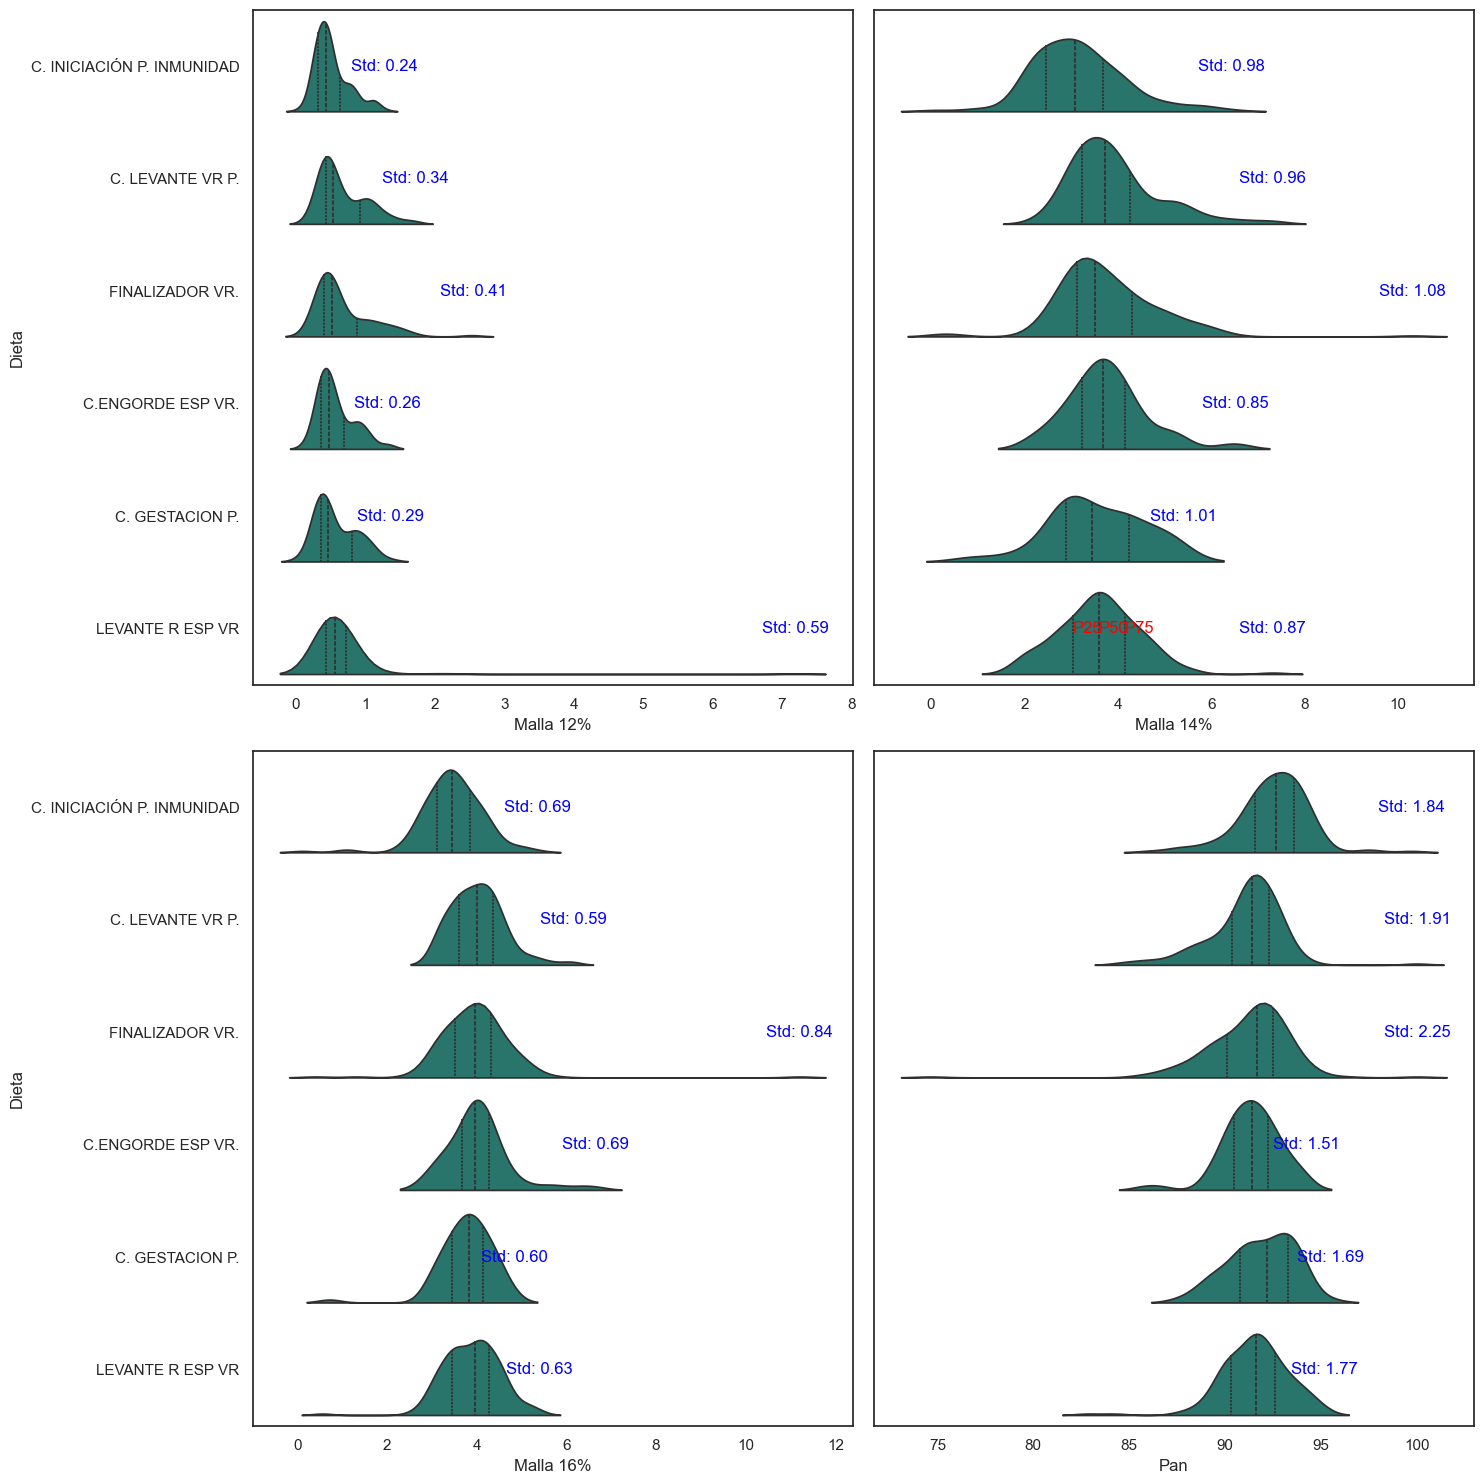

In [557]:

# Lista de variables y títulos para cada subplot
variables = ["Malla 12%", "Malla 14%", "Malla 16%", "Pan"]
titles = ["Malla 12%", "Malla 14%", "Malla 16%", "Pan"]

# Crear la figura con subplots 2x2 que comparten el eje y
fig, axs = plt.subplots(2, 2, figsize=(15, 15), sharey=True)

# Recorrer cada eje y variable para trazar los gráficos
for ax, var, title in zip(axs.flat, variables, titles):
    # Gráfico de violín
    sns.violinplot(data=df_filter_molienda_cut, y="Dieta", x=var, inner='quartile', split=True,
                   ax=ax, color="#1c8074")
    
    # Calcular y mostrar los percentiles y desviación estándar para cada categoría en 'Dieta'
    categorias = df_filter_molienda_cut["Dieta"].unique()
    yticks = ax.get_yticks()  # Obtener posiciones Y de las etiquetas de Dieta
    
    for i, (categoria, ypos) in enumerate(zip(categorias, yticks)):
        # Obtener datos por categoría
        datos_categoria = df_filter_molienda_cut[df_filter_molienda_cut["Dieta"] == categoria][var].dropna()
        
        # Calcular percentiles
        percentiles = np.percentile(datos_categoria, [25,50, 75])
        
        # Calcular desviación estándar
        std_dev = np.std(datos_categoria, ddof=1)  # ddof=1 para muestra
        
        # Obtener la mediana
        mediana = np.quantile(datos_categoria, 1)
        
        # Colocar los percentiles en el gráfico
        for p, label in zip(percentiles, ['P25','P50', 'P75']):
            if (categoria=='LEVANTE R ESP VR') and (var=="Malla 14%"):
                
                ax.text(p, ypos, label, 
                        va='center', 
                        fontsize=12, color='red')
        
        # Mostrar la desviación estándar en la posición de la mediana
        ax.text(mediana, ypos, f"Std: {std_dev:.2f}", 
                fontsize=12, color='blue', 
                ha='center', va='center',
                transform=ax.transData,
                #bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
                )

    # Etiquetas y títulos
    #ax.set_title(title)
    ax.set_xlabel(var)
    ax.set_ylabel("Dieta")

# Ajustar diseño para evitar superposición
plt.tight_layout()

# Guardar la imagen antes de mostrarla
plt.savefig("../images_facenda/granulometria_violin_plots.png", dpi=300)

# Mostrar la imagen en pantalla
plt.show()

# Cerrar la figura para liberar memoria
plt.close()


In [547]:
granularidades = ['Malla 10%', 'Malla 12%', 'Malla 14%', 'Malla 16%', 'Pan']
granulometria_dieta = build_stadistic(
    df=df_filter_molienda,
    metrics=granularidades, 
    group_=["Dieta",], # "Código"
    name_group="Granulometría",  
    name_file="granulometria_dieta")
granulometria_dieta

,Granulometría,Dieta,Media,Cantidad,Mínimo,P25,Mediana,P75,Máximo,Desviación estandar,Varianza,Error estandar
0,Malla 10%,C. FINALIZADOR P.,0.34,16,0.08,0.23,0.26,0.48,0.92,0.21,0.05,0.05
1,Malla 10%,C. GESTACION ESP 2,0.20,9,0.12,0.12,0.16,0.24,0.36,0.08,0.01,0.03
2,Malla 10%,C. GESTACION ESP P.,0.27,52,0.04,0.16,0.23,0.36,1.25,0.20,0.04,0.03
3,Malla 10%,C. GESTACION P.,0.27,70,0.04,0.12,0.25,0.36,1.04,0.21,0.04,0.02
5,Malla 10%,C. INICIACIÓN P. INMUNIDAD,0.36,148,0.04,0.18,0.32,0.48,1.16,0.23,0.05,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...
149,Pan,C.PRELACTANCIA H. ALIAR,89.35,8,86.92,87.04,88.74,91.48,92.68,2.45,6.02,0.87
150,Pan,C.REEMPLAZOS P. SI-B,92.00,33,86.28,91.32,92.16,92.92,94.84,1.69,2.87,0.29
151,Pan,C.TERNERAS H. ALIAR,94.20,11,90.88,93.22,94.32,95.54,96.28,1.64,2.70,0.50
152,Pan,FINALIZADOR VR.,91.22,206,74.66,90.08,91.64,92.52,100.00,2.25,5.07,0.16


In [550]:

pellets_measurements = ['Porcentaje Durabilidad']
build_stadistic(
    df=df_filter_pellet,
    metrics=pellets_measurements,
    group_=["Punto", "Dieta"],
    name_group="",
    name_file="porc_durabilidad_punto_dieta"
    )#.drop(columns="Tipo medida").sort_values(["Dieta", "Punto"])

/var/folders/1g/77kw2x4j5678s_87_sqc1fpc0000gp/T/ipykernel_78478/3739375030.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grad.sort_values(cols_,inplace=True)


,Punto,Dieta,Media,Cantidad,Mínimo,P25,Mediana,P75,Máximo,Desviación estandar,Varianza,Error estandar
14,ZARANDA 1,C. FINALIZADOR P.,92.17,7,90.8,91.30,92.0,92.40,95.0,1.42,2.01,0.54
15,ZARANDA 1,C. GESTACION ESP 2,91.48,8,89.2,90.00,91.2,91.90,96.2,2.16,4.67,0.76
0,POS-ENGRASE,C. GESTACION ESP P.,93.14,23,88.6,91.30,92.8,96.00,96.8,2.45,5.99,0.51
16,ZARANDA 1,C. GESTACION ESP P.,90.69,38,86.4,90.00,91.0,91.60,96.3,1.69,2.86,0.27
1,POS-ENGRASE,C. GESTACION P.,93.34,15,90.0,92.60,93.8,94.50,96.2,1.93,3.73,0.50
17,ZARANDA 1,C. GESTACION P.,91.16,66,85.6,90.40,91.2,92.00,94.0,1.43,2.06,0.18
2,POS-ENGRASE,C. INICIACIÓN P. INMUNIDAD,95.28,196,90.4,94.40,95.3,96.00,99.2,1.56,2.44,0.11
3,POS-ENGRASE,C. LACTANCIA PRIMERIZAS ESP P.,92.57,68,17.1,92.15,93.5,95.20,97.8,9.50,90.31,1.15
4,POS-ENGRASE,C. LACTANCIA PRIMERIZAS P.,94.03,63,90.0,93.00,94.4,95.10,97.6,1.67,2.80,0.21
21,ZARANDA 1,C. LACTANCIA PRIMERIZAS P.,92.80,6,90.1,92.00,92.2,93.90,95.9,2.04,4.18,0.83


In [551]:
pellets_measurements = ['Dureza']
build_stadistic(
    df=df_filter_pellet,
    metrics=pellets_measurements,
    group_=["Punto", "Dieta"],
    name_group="",
    name_file="dureza_punto_dieta"
    )

/var/folders/1g/77kw2x4j5678s_87_sqc1fpc0000gp/T/ipykernel_78478/3739375030.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grad.sort_values(cols_,inplace=True)


,Punto,Dieta,Media,Cantidad,Mínimo,P25,Mediana,P75,Máximo,Desviación estandar,Varianza,Error estandar
14,ZARANDA 1,C. FINALIZADOR P.,3.07,7,3.00,3.0,3.10,3.10,3.2,0.08,0.01,0.03
15,ZARANDA 1,C. GESTACION ESP 2,3.10,8,3.00,3.0,3.05,3.10,3.5,0.17,0.03,0.06
0,POS-ENGRASE,C. GESTACION ESP P.,4.48,23,2.80,3.0,3.10,3.55,30.0,5.58,31.16,1.16
16,ZARANDA 1,C. GESTACION ESP P.,3.30,38,3.00,3.0,3.15,3.44,4.0,0.35,0.12,0.06
1,POS-ENGRASE,C. GESTACION P.,3.33,15,3.00,3.1,3.30,3.50,4.0,0.29,0.08,0.07
17,ZARANDA 1,C. GESTACION P.,3.32,66,2.90,3.0,3.10,3.50,4.3,0.39,0.16,0.05
2,POS-ENGRASE,C. INICIACIÓN P. INMUNIDAD,5.60,196,2.70,3.0,3.00,3.10,500.0,35.50,1259.92,2.54
3,POS-ENGRASE,C. LACTANCIA PRIMERIZAS ESP P.,3.26,68,2.60,3.0,3.00,3.12,8.3,0.89,0.80,0.11
4,POS-ENGRASE,C. LACTANCIA PRIMERIZAS P.,3.10,63,2.80,3.0,3.10,3.10,4.0,0.17,0.03,0.02
21,ZARANDA 1,C. LACTANCIA PRIMERIZAS P.,3.12,6,3.00,3.0,3.05,3.10,3.5,0.19,0.04,0.08


In [556]:
dataframes["Punto"].value_counts()

Punto
TOLVA               1249
ZARANDA 1            857
ZARANDA 2            421
POS-ENGRASE          393
ACONDICIONADOR 1       1
ACONDICIONADOR 2       1
ACONDICIONADOR 3       1
ENFRIADORA             1
DADO PELLET 2          1
ENFRIADORA 1           1
FINOS DEL DADO         1
ENFRIADORA 1 Y 2       1
Name: count, dtype: int64

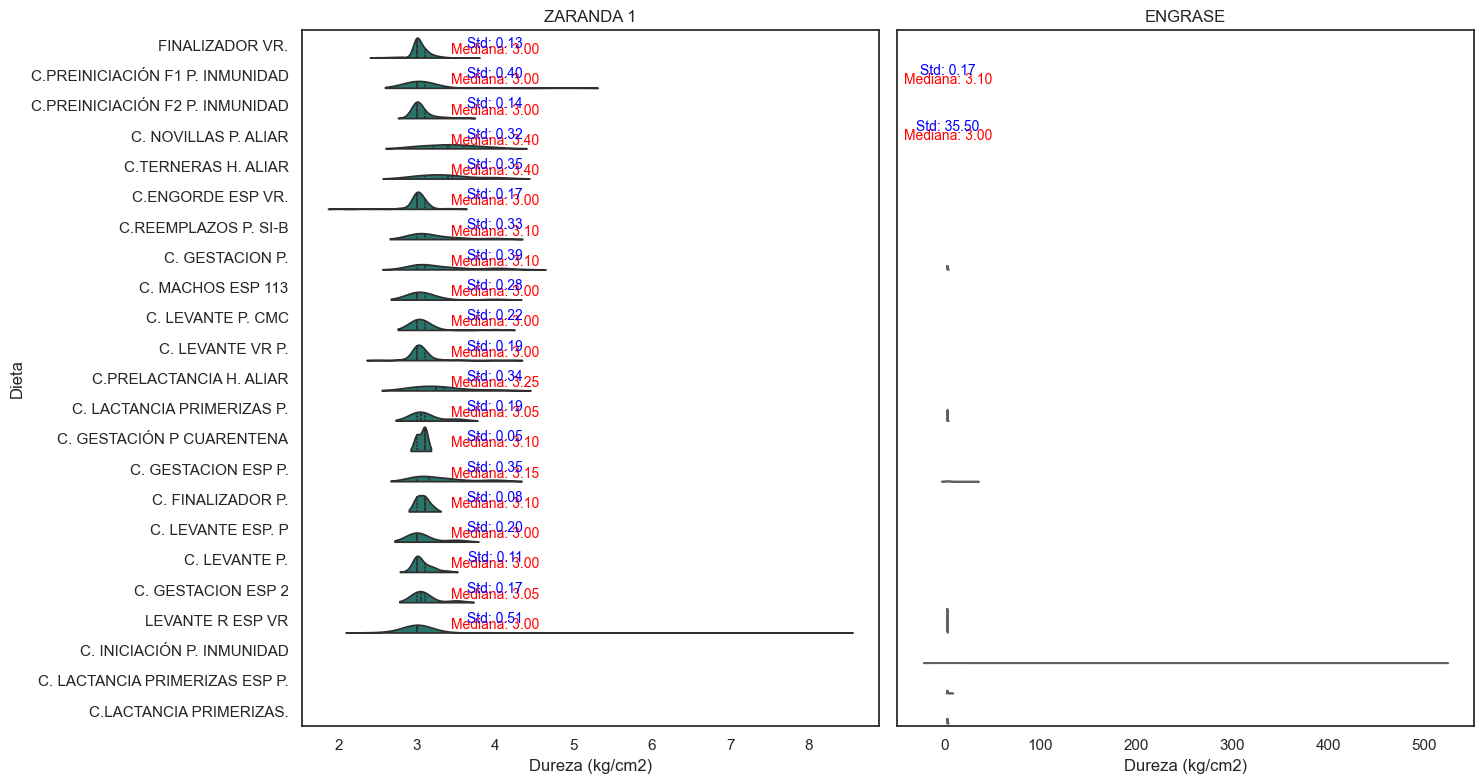

In [560]:

variables = ['Dureza']
titles = ['Dureza']
df_filter_pellet_zaranda = df_filter_pellet[df_filter_pellet["Punto"] == "ZARANDA 1"]
df_filter_pellet_engrase = df_filter_pellet[df_filter_pellet["Punto"] != "ZARANDA 1"]

# Filtrar categorías con menos de 5 datos
min_datos = 5

# Para ZARANDA
valid_cats_zaranda = df_filter_pellet_zaranda['Dieta'].value_counts()
valid_cats_zaranda = valid_cats_zaranda[valid_cats_zaranda >= min_datos].index
df_filter_pellet_zaranda = df_filter_pellet_zaranda[df_filter_pellet_zaranda['Dieta'].isin(valid_cats_zaranda)]

# Para ENGRASE
valid_cats_engrase = df_filter_pellet_engrase['Dieta'].value_counts()
valid_cats_engrase = valid_cats_engrase[valid_cats_engrase >= min_datos].index
df_filter_pellet_engrase = df_filter_pellet_engrase[df_filter_pellet_engrase['Dieta'].isin(valid_cats_engrase)]

# Crear la figura con subplots 1x2 que comparten el eje y
fig, axs = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

# Graficar en la columna 1: df_filter_pellet_zaranda
sns.violinplot(data=df_filter_pellet_zaranda, y='Dieta', x='Dureza', 
               inner='quartile', split=True, ax=axs[0], color="#1c8074")

# Título de la columna 1
axs[0].set_title("ZARANDA 1")
axs[0].set_xlabel("Dureza (kg/cm2)")
axs[0].set_ylabel("Dieta")

# Graficar en la columna 2: df_filter_pellet_engrase
sns.violinplot(data=df_filter_pellet_engrase, y='Dieta', x='Dureza', 
               inner='quartile', split=True, ax=axs[1], color="#94AF92")

# Título de la columna 2
axs[1].set_title("ENGRASE")
axs[1].set_xlabel("Dureza (kg/cm2)")
axs[1].set_ylabel("")

# Calcular y mostrar la mediana y desviación estándar para cada categoría
for ax_idx, (ax, df, title) in enumerate(zip(axs, [df_filter_pellet_zaranda, df_filter_pellet_engrase], ["ZARANDA 1", "ENGRASE"])):
    categorias = df["Dieta"].unique()
    for i, categoria in enumerate(categorias):
        # Obtener datos por categoría
        datos_categoria = df[df["Dieta"] == categoria]['Dureza'].dropna()

        # Verificar si hay suficientes datos
        if len(datos_categoria) < min_datos:
            continue
        
        # Calcular la mediana
        mediana = np.median(datos_categoria)
        mediana1 = np.quantile(datos_categoria,0.90)

        
        # Calcular desviación estándar
        std_dev = np.std(datos_categoria, ddof=1)
        
         # Condicional para personalizar la ubicación y estilo del texto según el subplot
        if ax_idx == 0:  # Columna 1: ZARANDA 1
            # Mostrar la mediana en rojo en X=4, Y arriba de la mediana
            ax.text(4, i + 0.15, f"Mediana: {mediana:.2f}", 
                    fontsize=10, color='red', 
                    ha='center', va='center')

            # Mostrar la desviación estándar en azul debajo de la mediana
            ax.text(4, i - 0.05, f"Std: {std_dev:.2f}", 
                    fontsize=10, color='blue', 
                    ha='center', va='center')

        else:  # Columna 2: ENGRASE
            # Mostrar la mediana en verde en la posición de la mediana
            if i ==1:
                ax.text(mediana+.9, i+ 0.15, f"Mediana: {mediana:.2f}", 
                        fontsize=10, color='red', 
                        ha='center', va='center')

                # Mostrar la desviación estándar en naranja justo debajo de la mediana
                ax.text(mediana+.9, i - 0.15, f"Std: {std_dev:.2f}", 
                        fontsize=10, color='blue', 
                        ha='center', va='center')
            if i ==0:
                ax.text(mediana+.9, 3, f"Mediana: {mediana:.2f}", 
                        fontsize=10, color='red', 
                        ha='center', va='center')

                # Mostrar la desviación estándar en naranja justo debajo de la mediana
                ax.text(mediana+.9, 2.7, f"Std: {std_dev:.2f}", 
                        fontsize=10, color='blue', 
                        ha='center', va='center')
        
        

# Ajuste del layout para evitar superposición
plt.tight_layout()

# Guardar la imagen antes de mostrarla
plt.savefig("../images_facenda/dureza_dieta_punto_violin_plots.png", dpi=300)

# Mostrar la imagen en pantalla
plt.show()

# Cerrar la figura para liberar memoria
plt.close()


0 C. LEVANTE VR P.
1 FINALIZADOR VR.
2 C.ENGORDE ESP VR.
3 LEVANTE R ESP VR
4 C. FINALIZADOR P.
5 C.LEVANTE P.
6 C. ENGORDE ESP P.
7 C. LEVANTE ESP. P
0 LEVANTE R ESP VR
1 FINALIZADOR VR.


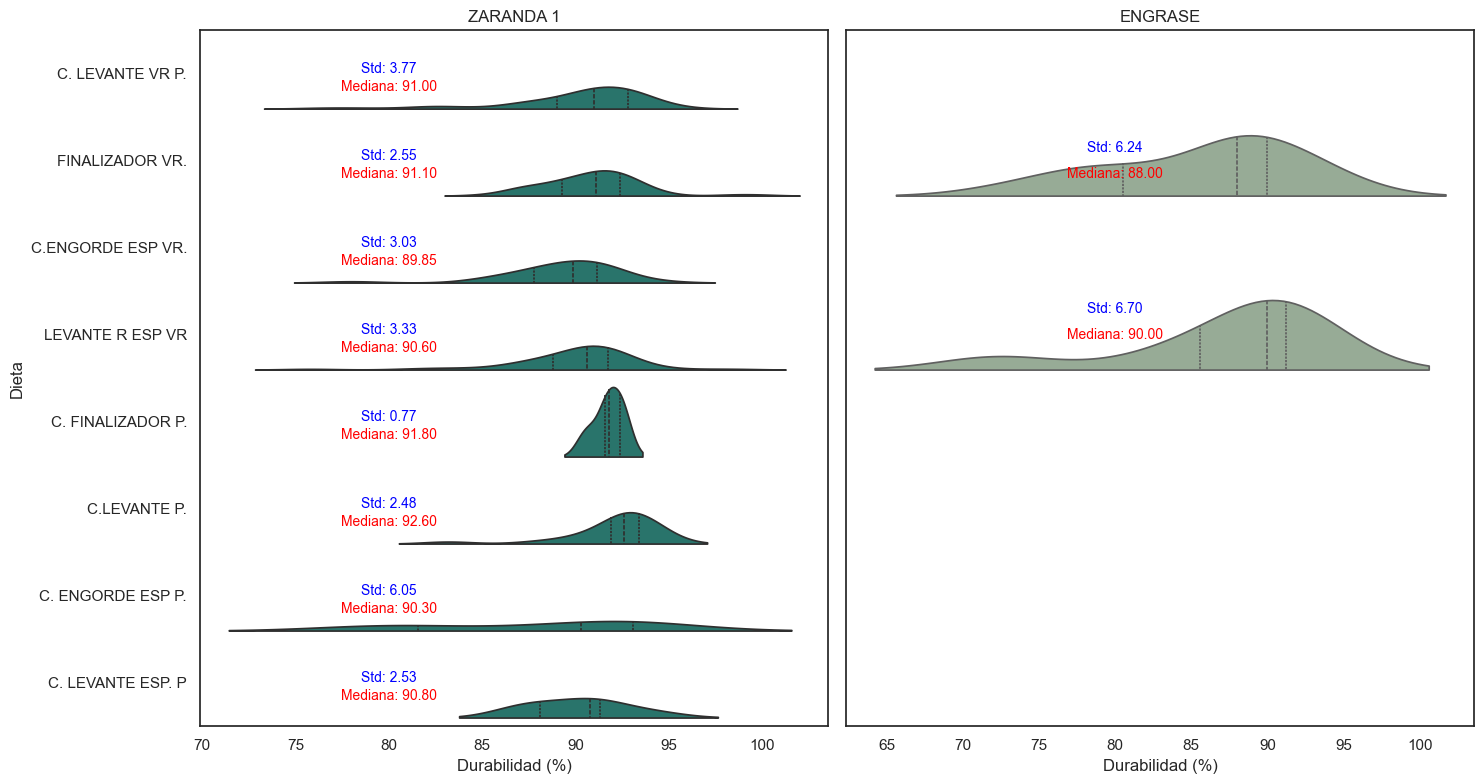

In [451]:

variables = ['Porcentaje Durabilidad']
titles = ['Porcentaje Durabilidad']
df_filter_pellet_zaranda = df_filter_pellet[df_filter_pellet["Punto"] == "ZARANDA 1"]
df_filter_pellet_engrase = df_filter_pellet[df_filter_pellet["Punto"] != "ZARANDA 1"]

# Filtrar categorías con menos de 5 datos
min_datos = 5

# Para ZARANDA
valid_cats_zaranda = df_filter_pellet_zaranda['Dieta'].value_counts()
valid_cats_zaranda = valid_cats_zaranda[valid_cats_zaranda >= min_datos].index
df_filter_pellet_zaranda = df_filter_pellet_zaranda[df_filter_pellet_zaranda['Dieta'].isin(valid_cats_zaranda)]

# Para ENGRASE
valid_cats_engrase = df_filter_pellet_engrase['Dieta'].value_counts()
valid_cats_engrase = valid_cats_engrase[valid_cats_engrase >= min_datos].index
df_filter_pellet_engrase = df_filter_pellet_engrase[df_filter_pellet_engrase['Dieta'].isin(valid_cats_engrase)]

# Crear la figura con subplots 1x2 que comparten el eje y
fig, axs = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

# Graficar en la columna 1: df_filter_pellet_zaranda
sns.violinplot(data=df_filter_pellet_zaranda, y='Dieta', x='Porcentaje Durabilidad', 
               inner='quartile', split=True, ax=axs[0], color="#1c8074")

# Título de la columna 1
axs[0].set_title("ZARANDA 1")
axs[0].set_xlabel("Durabilidad (%)")
axs[0].set_ylabel("Dieta")

# Graficar en la columna 2: df_filter_pellet_engrase
sns.violinplot(data=df_filter_pellet_engrase, y='Dieta', x='Porcentaje Durabilidad', 
               inner='quartile', split=True, ax=axs[1], color="#94AF92")

# Título de la columna 2
axs[1].set_title("ENGRASE")
axs[1].set_xlabel("Durabilidad (%)")
axs[1].set_ylabel("")

# Calcular y mostrar la mediana y desviación estándar para cada categoría
for ax_idx, (ax, df, title) in enumerate(zip(axs, [df_filter_pellet_zaranda, df_filter_pellet_engrase], ["ZARANDA 1", "ENGRASE"])):
    categorias = df["Dieta"].unique()
    for i, categoria in enumerate(categorias):
        print(i, categoria)
        # Obtener datos por categoría
        datos_categoria = df[df["Dieta"] == categoria]['Porcentaje Durabilidad'].dropna()

        # Verificar si hay suficientes datos
        if len(datos_categoria) < min_datos:
            continue
        
        # Calcular la mediana
        mediana = np.median(datos_categoria)
        mediana1 = np.quantile(datos_categoria,0.90)

        
        # Calcular desviación estándar
        std_dev = np.std(datos_categoria, ddof=1)
        
         # Condicional para personalizar la ubicación y estilo del texto según el subplot
        if ax_idx == 0:  # Columna 1: ZARANDA 1
            # Mostrar la mediana en rojo en X=4, Y arriba de la mediana
            ax.text(80, i + 0.15, f"Mediana: {mediana:.2f}", 
                    fontsize=10, color='red', 
                    ha='center', va='center')

            # Mostrar la desviación estándar en azul debajo de la mediana
            ax.text(80, i - 0.05, f"Std: {std_dev:.2f}", 
                    fontsize=10, color='blue', 
                    ha='center', va='center')

        else:  # Columna 2: ENGRASE
            # Mostrar la mediana en verde en la posición de la mediana
            if i ==1:
                ax.text(80, i+ 0.15, f"Mediana: {mediana:.2f}", 
                        fontsize=10, color='red', 
                        ha='center', va='center')

                # Mostrar la desviación estándar en naranja justo debajo de la mediana
                ax.text(80, i - 0.15, f"Std: {std_dev:.2f}", 
                        fontsize=10, color='blue', 
                        ha='center', va='center')
            if i ==0:
                ax.text(80, 3, f"Mediana: {mediana:.2f}", 
                        fontsize=10, color='red', 
                        ha='center', va='center')

                # Mostrar la desviación estándar en naranja justo debajo de la mediana
                ax.text(80, 2.7, f"Std: {std_dev:.2f}", 
                        fontsize=10, color='blue', 
                        ha='center', va='center')
        
        

# Ajuste del layout para evitar superposición
plt.tight_layout()

# Guardar la imagen antes de mostrarla
plt.savefig("../images/durabilidad_dieta_punto_violin_plots.png", dpi=300)

# Mostrar la imagen en pantalla
plt.show()

# Cerrar la figura para liberar memoria
plt.close()


In [51]:

pellets_measurements = ['TERMOMETRO PLANTA', 'TERMOMETRO AGROINDUSTRIA']
build_stadistic(
    df=temp,
    metrics=pellets_measurements,
    group_=["Punto"],
    name_group="Instrumento",
    name_file="temp_punto"
    )

,Instrumento,Punto,Media,Cantidad,Mínimo,Quantil25,Mediana,Quantil75,Máximo,Desviacion Estandar,Varianza,Error Estandar
0,TERMOMETRO PLANTA,ACONDICIONADOR 1,71.92,63,56.02,71.20,72.31,73.82,80.12,3.65,13.32,0.38
3,TERMOMETRO AGROINDUSTRIA,ACONDICIONADOR 1,71.67,63,54.00,70.30,71.70,74.30,81.50,4.39,19.28,0.46
4,TERMOMETRO AGROINDUSTRIA,ENFRIADORA 1,32.32,63,29.00,31.05,32.30,33.15,39.40,1.99,3.95,0.21
5,TERMOMETRO AGROINDUSTRIA,PELLET 1,82.64,63,70.00,80.60,83.10,84.75,93.30,3.44,11.82,0.36


In [52]:
build_stadistic(
    df=temp,
    metrics=pellets_measurements,
    group_=["Punto", "Dieta"],
    name_group="Instrumento",
    name_file="temp_punto_dieta"
    )

,Instrumento,Punto,Dieta,Media,Cantidad,Mínimo,Quantil25,Mediana,Quantil75,Máximo,Desviacion Estandar,Varianza,Error Estandar
5,TERMOMETRO PLANTA,ACONDICIONADOR 1,FINAL VR,71.65,10,69.34,71.60,71.82,72.21,72.54,0.91,0.83,0.29
7,TERMOMETRO PLANTA,ACONDICIONADOR 1,FINALIZADOR VR.,69.84,6,56.02,70.61,72.48,73.51,74.24,6.92,47.95,2.83
9,TERMOMETRO PLANTA,ACONDICIONADOR 1,LEVANTE ESP VR,71.84,8,62.23,72.47,72.56,73.80,74.85,3.99,15.89,1.41
10,TERMOMETRO PLANTA,ACONDICIONADOR 1,LEVANTE VR,72.12,18,64.06,71.24,72.13,73.39,80.12,3.25,10.59,0.77
38,TERMOMETRO AGROINDUSTRIA,ACONDICIONADOR 1,FINAL VR,70.75,10,54.00,71.10,71.30,72.20,81.50,6.71,44.97,2.12
40,TERMOMETRO AGROINDUSTRIA,ACONDICIONADOR 1,FINALIZADOR VR.,71.10,6,64.80,70.28,71.10,73.28,75.60,3.71,13.75,1.51
42,TERMOMETRO AGROINDUSTRIA,ACONDICIONADOR 1,LEVANTE ESP VR,70.25,8,62.00,69.85,71.95,72.40,73.90,4.00,15.99,1.41
43,TERMOMETRO AGROINDUSTRIA,ACONDICIONADOR 1,LEVANTE VR,72.09,18,64.10,70.22,71.80,75.10,80.40,4.06,16.45,0.96
49,TERMOMETRO AGROINDUSTRIA,ENFRIADORA 1,FINAL VR,31.17,10,29.10,30.32,30.95,32.15,33.50,1.38,1.91,0.44
51,TERMOMETRO AGROINDUSTRIA,ENFRIADORA 1,FINALIZADOR VR.,34.97,6,32.90,34.20,34.40,34.83,39.00,2.09,4.37,0.85


In [53]:

pellets_measurements = ['TERMOMETRO PLANTA', 'TERMOMETRO AGROINDUSTRIA']
build_stadistic(
    df=temp,
    metrics=pellets_measurements,
    group_=["Orden producción", "Dieta"],
    name_group="Instrumento",
    name_file="temp_op"
    )

,Instrumento,Orden producción,Dieta,Media,Cantidad,Mínimo,Quantil25,Mediana,Quantil75,Máximo,Desviacion Estandar,Varianza,Error Estandar
0,TERMOMETRO PLANTA,1.0,FINALIZADOR VR.,69.84,6,56.02,70.61,72.48,73.51,74.24,6.92,47.95,1.63
34,TERMOMETRO AGROINDUSTRIA,1.0,FINALIZADOR VR.,62.56,18,32.90,35.92,71.10,79.58,84.50,20.77,431.20,4.89
35,TERMOMETRO AGROINDUSTRIA,1.0,LEVANTE VR,65.58,6,29.80,42.05,75.25,85.50,93.30,27.70,767.44,11.31
37,TERMOMETRO AGROINDUSTRIA,17.0,C.LEVANTE VR,65.64,6,33.03,43.66,76.80,84.66,87.30,25.66,658.43,10.48
40,TERMOMETRO AGROINDUSTRIA,33.0,C.FINALIZACION VR,62.00,6,32.00,42.88,71.10,78.18,83.80,23.22,539.08,9.48
50,TERMOMETRO AGROINDUSTRIA,77.0,ENGORDE ESP VR,63.77,6,30.00,43.15,74.75,80.85,87.60,25.60,655.40,10.45
55,TERMOMETRO AGROINDUSTRIA,94.0,LEVANTE VR,62.37,9,32.50,33.10,75.50,77.20,82.80,22.53,507.67,7.51
56,TERMOMETRO AGROINDUSTRIA,95.0,FINAL VR,58.98,9,29.70,32.00,71.10,79.10,81.50,22.56,508.99,7.52
57,TERMOMETRO AGROINDUSTRIA,97.0,LEVANTE ESP VR,62.65,6,31.90,43.25,72.30,79.60,83.80,23.65,559.50,9.66
58,TERMOMETRO AGROINDUSTRIA,100.0,FINAL VR,60.32,6,30.30,41.92,71.25,76.12,79.20,22.76,517.89,9.29


In [454]:
temp

,index,FECHA TOMA DE MUESTRA,HORA,TURNO,Punto,TERMOMETRO PLANTA,TERMOMETRO AGROINDUSTRIA,Código,Dieta,Orden producción,RESPONSABLE,OBSERVACIONES,dif1
0,0,2024-11-19,16:20:00,1.0,ACONDICIONADOR 1,80.12,80.4,200541.0,LEVANTE VR,1.0,ANGELA AFANADOR,NaN,None
1,1,2024-11-19,16:20:00,NaN,PELLET 1,NaN,93.3,200541.0,LEVANTE VR,1.0,ANGELA AFANADOR,NaN,16:20:00
2,2,NaT,NaN,NaN,ENFRIADORA 1,NaN,29.8,200541.0,LEVANTE VR,1.0,ANGELA AFANADOR,NaN,NaN
3,3,2024-11-20,11:50:00,1.0,ACONDICIONADOR 1,68.10,70.1,200541.0,LEVANTE VR,1.0,ANGELA AFANADOR,NaN,NaN
4,4,2024-11-20,11:50:00,NaN,PELLET 1,NaN,87.2,200541.0,LEVANTE VR,1.0,ANGELA AFANADOR,NaN,11:50:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,43,NaT,NaN,NaN,PELLET 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266,44,NaT,NaN,NaN,ENFRIADORA 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267,45,NaT,NaN,NaN,ACONDICIONADOR 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268,46,NaT,NaN,NaN,PELLET 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [456]:
temp_pellet = temp[temp["Punto"]=='PELLET 1']
temp_pellet

,index,FECHA TOMA DE MUESTRA,HORA,TURNO,Punto,TERMOMETRO PLANTA,TERMOMETRO AGROINDUSTRIA,Código,Dieta,Orden producción,RESPONSABLE,OBSERVACIONES,dif1
1,1,2024-11-19,16:20:00,NaN,PELLET 1,NaN,93.3,200541.0,LEVANTE VR,1.0,ANGELA AFANADOR,NaN,16:20:00
4,4,2024-11-20,11:50:00,NaN,PELLET 1,NaN,87.2,200541.0,LEVANTE VR,1.0,ANGELA AFANADOR,NaN,11:50:00
7,7,2024-11-22,19:00:00,NaN,PELLET 1,NaN,80.9,200544.0,FINALIZADOR VR.,1.0,ANGELA AFANADOR,NaN,19:00:00
10,10,2024-11-23,14:24:00,NaN,PELLET 1,NaN,75.3,200544.0,FINALIZADOR VR.,1.0,ANGELA AFANADOR,NaN,14:24:00
13,13,2024-11-25,14:00:00,NaN,PELLET 1,NaN,84.5,200544.0,FINALIZADOR VR.,1.0,ANGELA AFANADOR,NaN,14:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,34,NaT,NaN,NaN,PELLET 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259,37,NaT,NaN,NaN,PELLET 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262,40,NaT,NaN,NaN,PELLET 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
265,43,NaT,NaN,NaN,PELLET 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


IndexError: index -1 is out of bounds for axis 0 with size 0

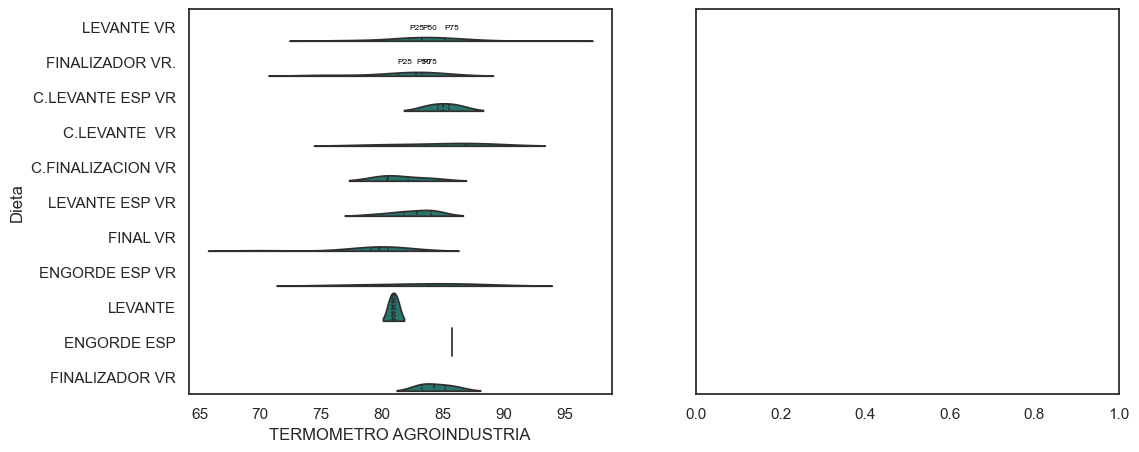

In [459]:


# Lista de variables y títulos para cada subplot
variables = ['TERMOMETRO AGROINDUSTRIA','TERMOMETRO PLANTA']
titles = ['TERMOMETRO AGROINDUSTRIA', 'TERMOMETRO PLANTA']

# Crear la figura con subplots 1x2 que comparten el eje y
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Recorrer cada eje y variable para trazar los gráficos
for ax, var, title in zip(axs.flat, variables, titles):
    # Gráfico de violín
    sns.violinplot(data=temp_pellet, y='Dieta', x=var, inner='quartile', split=True,
                   ax=ax, color="#1c8074")
    
    # Calcular y mostrar los percentiles para cada categoría en 'Dieta agrupada'
    categorias = temp_pellet["Dieta"].unique()
    for i, categoria in enumerate(categorias):
        # Obtener datos por categoría
        datos_categoria = temp_pellet[temp_pellet["Dieta"] == categoria][var].dropna()
        
        # Calcular percentiles
        percentiles = np.percentile(datos_categoria, [25, 50, 75])
        
        # Colocar los nombres en una posición personalizada (esquina superior derecha)
        for p, label in zip(percentiles, ['P25', 'P50', 'P75']):
            ax.text(p, i, label, 
                    ha='left', va='center', 
                    fontsize=6, color='black',
                    #bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
                    )
    
    # Etiquetas de los ejes
    uni = '(%)' if var == "Temp" else "(kg/cm2)"
    ax.set_xlabel(f'{var} {uni}')
    ax.set_ylabel("Dieta")
    #ax.set_title(title)
    

# Ajuste del layout
plt.tight_layout()

# Guardar la imagen antes de mostrarla
plt.savefig("../images/temperatura_pellet_violin_plots.png", dpi=300)

# Mostrar la imagen en pantalla
plt.show()

# Cerrar la figura para liberar memoria
plt.close()
